# fastReach Data Exploration

## Loading Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
import pickle

pID = '4'

path = "/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/"
data_fname = '/data.csv'
data = pd.read_csv(path+pID+data_fname)

# selected EEG chans
#chans_fname = '/chans.csv'
#chans = np.array(pd.read_csv(path+pID+chans_fname))
#filename = path+pID+'/chans_'+pID+'_eeg.sav'
#pickle.dump(chans, open(filename, 'wb'))

## Build feature matrix EEG

In [2]:
# import feature computation functions

# EEG features
# 1. windowed means over EEG channels
win_mean_size = 25
win_mean = np.arange(len(data))//win_mean_size

win_mean = data.groupby(win_mean).mean()

# # EMG features
# def rms(values):
#     return np.sqrt(sum(values**2)/len(values))

# emg = data.iloc[:,[0,3]]
# emg = emg.groupby(['epoch_ix'])["emg"].apply(rms)


# Train & Inspect Models

## EEG

In [3]:
clf = LDA(solver='lsqr', shrinkage='auto')

a = win_mean.iloc[:,5:].values

clf.fit(win_mean.iloc[:,5:].values, win_mean.rp_class)
# print(clf.coef_)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

eeg_dim1 = 5
cv_results = cross_val_score(clf, data.iloc[:,eeg_dim1:].values, data.rp_class, cv=kfolds)
cv_average = cv_results.mean()
print(cv_average)
st_deviation = cv_results.std()

filename = path+pID+'/model_'+pID+'_eeg.sav'
pickle.dump(clf, open(filename, 'wb'))


0.6235510204081632


## Motion

In [4]:
clf = LDA()

# feat = win_mean.iloc[:,2].values
# clf.fit(feat.reshape(-1, 1), win_mean.rp_class)

motion_dim = 3
clf.fit(data.iloc[:,motion_dim].values.reshape(-1,1), data.rp_class)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

# cv_results = cross_val_score(clf, feat.reshape(-1, 1), win_mean.rp_class, cv=kfolds)
cv_results = cross_val_score(clf, data.iloc[:,3].values.reshape(-1,1), data.rp_class, cv=kfolds)
cv_average = cv_results.mean()
print(cv_average)
st_deviation = cv_results.std()

filename = path+pID+'/model_'+pID+'_motion.sav'
pickle.dump(clf, open(filename, 'wb'))

0.9060816326530612


# Plots

## Features

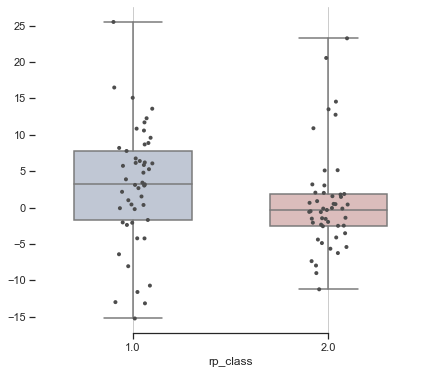

In [5]:
# g = sns.lmplot(x='Motion',y='Motion', data=data, hue='rp_class', fit_reg=False)
# g.set_axis_labels('{} muscle1'.format(feature), '{} muscle2'.format(feature))

data_short = data.groupby(['epoch_ix']).mean()

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
group_var = "rp_class"
val_var = "Cz"
sns.boxplot(x=group_var, y=val_var, data=data_short,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x=group_var, y=val_var, data=data_short,
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)


## Linear Discriminant(s) Plot

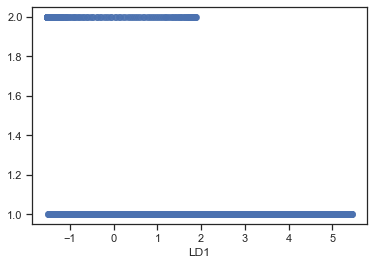

In [6]:
clf = LDA(n_components=1)
# data.loc[0,:]=np.zeros(data.shape[1])
# data_short = data.grouby(['epoch_ix']).mean()

transf_lda = clf.fit_transform(data.iloc[:,3].values.reshape(-1,1), data.rp_class)

# print(transf_lda)

plt.xlabel('LD1')
# plt.ylabel('LD2')
plt.scatter(
    x=transf_lda[:,0],
    y=data.rp_class,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

# import matplotlib.pyplot as plt
# for label,marker,color in zip(range(1,3),('o','^'),('red','blue')):
#     plt.scatter(x=transf_lda[:,0][data.rp_class == label],
#            y=[data.rp_class == label], marker=marker,
#            color=color, alpha=0.7, label='class {}'.format(label))

# #plt.xlabel('vector 1')
# #plt.ylabel('vector 2')

# plt.legend(loc='lower right')
# plt.title('dimensionality reduction for data set')

# plt.show()

In [13]:
data.iloc[:,3]

0        0.000284
1        0.000297
2        0.000311
3        0.000326
4        0.000341
           ...   
24495    0.000012
24496    0.000014
24497    0.000016
24498    0.000017
24499    0.000018
Name: Motion, Length: 24500, dtype: float64

## ERP Readiness Potential Plot

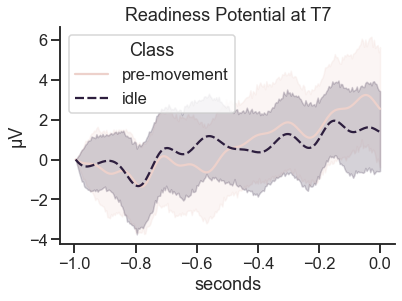

In [7]:
sns.set_theme(style="ticks")
sns.set_context("talk")

electrode = "T7"

# Plot the responses for different events and regions
g = sns.lineplot(x="sample", y=electrode,
             hue="rp_class", style="rp_class",
             data=data)
sns.despine()
g.set(xlabel='seconds', ylabel='\u03bcV', title='Readiness Potential at '+electrode)

# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['pre-movement', 'idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

## Trial Progression

In [8]:
data_fname = '/data_for_plot.csv'
data = pd.read_csv(path+pID+data_fname)

sns.set(rc={'figure.figsize':(16,4)})

sns.set_theme(style="ticks")
sns.set_context("talk")

# Plot the responses for different events and regions
g = sns.lineplot(x="sample", y=data.columns[3], 
    hue="type", style="type", data=data)
sns.despine()


g.set(xlabel='seconds', ylabel='a.u.', title='Trial Progression')

xcoords = [-10, -1, 0]
for xc in xcoords:
    plt.axvline(x=xc, color='k', linestyle='--', alpha=.6)

electrode = "T7"
# legend
leg = g.legend_
new_title = 'Data'
leg.set_title(new_title)
# replace labels
new_labels = ['Hand Velocity', 'Electrode '+electrode]
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

plt.savefig("figure.pdf") # save as png

FileNotFoundError: [Errno 2] No such file or directory: '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/4/data_for_plot.csv'